In [13]:
import os
import cv2
import sys
import random
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [2]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

## Creating image mask

In [3]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS] # To take the rgb format
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    # Now we take all masks associated with that image and combine them into one single mask
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        single_mask = imread(path + '/masks/' + mask_file)
        single_mask = np.expand_dims(resize(single_mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, single_mask)
    # Y_train is now our single mask associated with our image
    Y_train[n] = mask

# test images resize
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img


Getting and resizing training images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [15:51<00:00,  1.42s/it]

Getting and resizing test images ... 



100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:04<00:00, 15.35it/s]


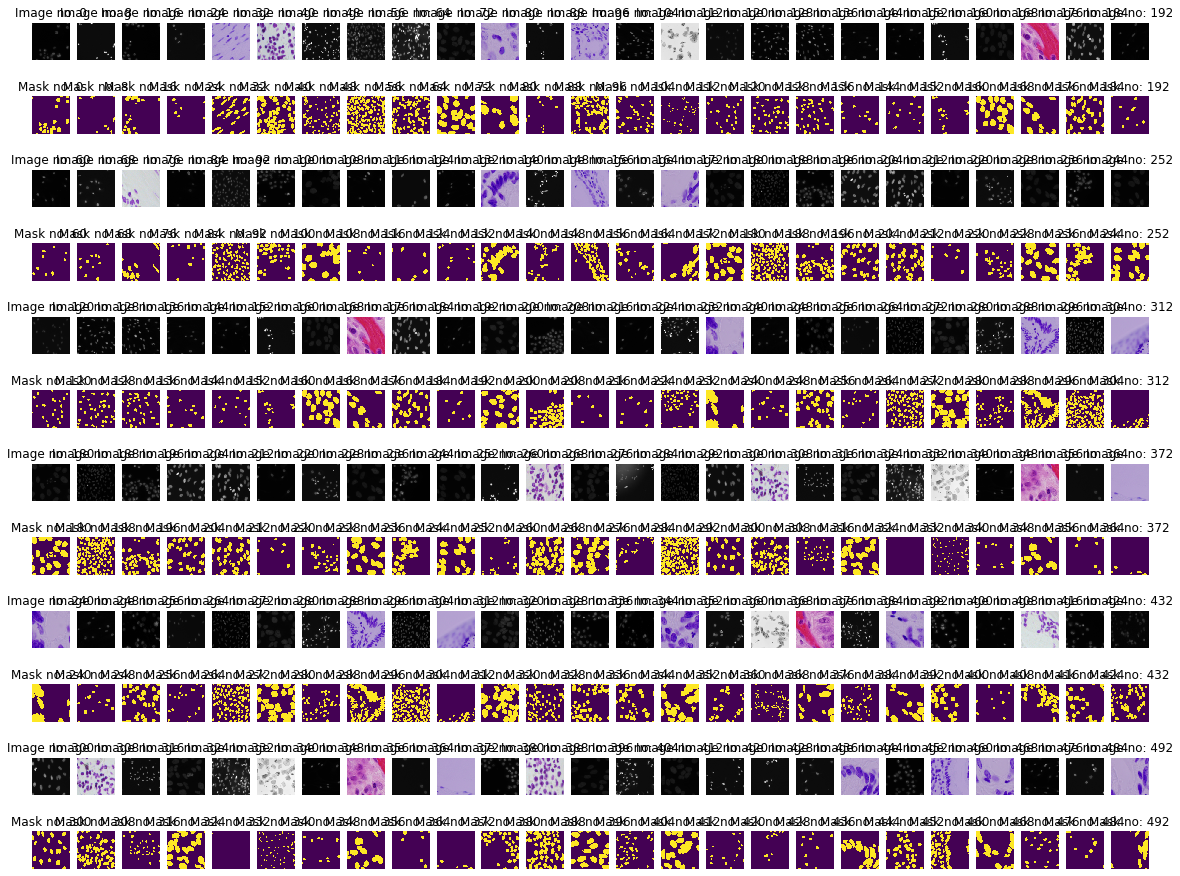

In [7]:
# Examples of training images and masks
plt.figure(figsize=(20,16))
x, y = 25,6
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*60 + j*8
        plt.imshow(X_train[pos])
        plt.title('Image no: {}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask no: {}'.format(pos))
        plt.axis('off')
        
plt.show()

### Basic IOU metric for calculating loss

In [8]:
# def basic_iou(y_true, y_pred):
#     prec = []
#     for t in np.arange(0.5, 1.0, 0.05):
#         y_pred_ = tf.to_int32(y_pred > t)
#         score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
#         K.get_session().run(tf.local_variables_initializer())
#         with tf.control_dependencies([up_opt]):
#             score = tf.identity(score)
#         prec.append(score)
#     return K.mean(K.stack(prec), axis=0)

### Optimized IOU metric

In [11]:
# Optimization idea from Kaggle notebook https://www.kaggle.com/aglotero/another-iou-metric

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.compat.v1.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

### U-NET Architecture

In [22]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [24]:
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [25]:
model_path = "nuclei_unet_relu.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 4, verbose = 1, 
                              min_delta = 0.0001)

# Fit our model 
results = model.fit(X_train, Y_train, validation_split=0.2,
                    batch_size=16, epochs=40, 
                    callbacks=[earlystop, checkpoint, reduce_lr])

Train on 536 samples, validate on 134 samples
Epoch 1/40
536/536 [==============================] - 14s 26ms/step - loss: 0.5957 - my_iou_metric: 0.0000e+00 - val_loss: 0.4074 - val_my_iou_metric: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.40739, saving model to nuclei_unet_relu.h5
Epoch 2/40
536/536 [==============================] - 7s 14ms/step - loss: 0.3353 - my_iou_metric: 0.0497 - val_loss: 0.2269 - val_my_iou_metric: 0.1652

Epoch 00002: val_loss improved from 0.40739 to 0.22694, saving model to nuclei_unet_relu.h5
Epoch 3/40
536/536 [==============================] - 7s 13ms/step - loss: 0.2005 - my_iou_metric: 0.2278 - val_loss: 0.1552 - val_my_iou_metric: 0.3190

Epoch 00003: val_loss improved from 0.22694 to 0.15520, saving model to nuclei_unet_relu.h5
Epoch 4/40
536/536 [==============================] - 7s 13ms/step - loss: 0.1618 - my_iou_metric: 0.3081 - val_loss: 0.1360 - val_my_iou_metric: 0.4122

Epoch 00004: val_loss improved from 0.15520 to 0.13596, s


Epoch 00035: val_loss improved from 0.07024 to 0.06962, saving model to nuclei_unet_relu.h5
Epoch 36/40
536/536 [==============================] - 7s 13ms/step - loss: 0.0809 - my_iou_metric: 0.5479 - val_loss: 0.0701 - val_my_iou_metric: 0.6121

Epoch 00036: val_loss did not improve from 0.06962
Epoch 37/40
536/536 [==============================] - 7s 13ms/step - loss: 0.0811 - my_iou_metric: 0.5459 - val_loss: 0.0698 - val_my_iou_metric: 0.6163

Epoch 00037: val_loss did not improve from 0.06962
Epoch 38/40
536/536 [==============================] - 7s 13ms/step - loss: 0.0808 - my_iou_metric: 0.5484 - val_loss: 0.0697 - val_my_iou_metric: 0.6230

Epoch 00038: val_loss did not improve from 0.06962
Epoch 39/40
536/536 [==============================] - 7s 13ms/step - loss: 0.0808 - my_iou_metric: 0.5461 - val_loss: 0.0702 - val_my_iou_metric: 0.6153

Epoch 00039: val_loss did not improve from 0.06962

Epoch 00039: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Ep

In [26]:
#To see the predictions
model = load_model('nuclei_unet_relu.h5', 
                   custom_objects={'my_iou_metric': my_iou_metric})

#80:20 split of train and test set in a successive order
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.2):], verbose=1)

# predictions which will be considered true
final_preds_train = (preds_train > 0.5).astype(np.uint8)
final_preds_val = (preds_val > 0.5).astype(np.uint8)

536/536 [==============================] - 1s 2ms/step


### Displaying Prediction results

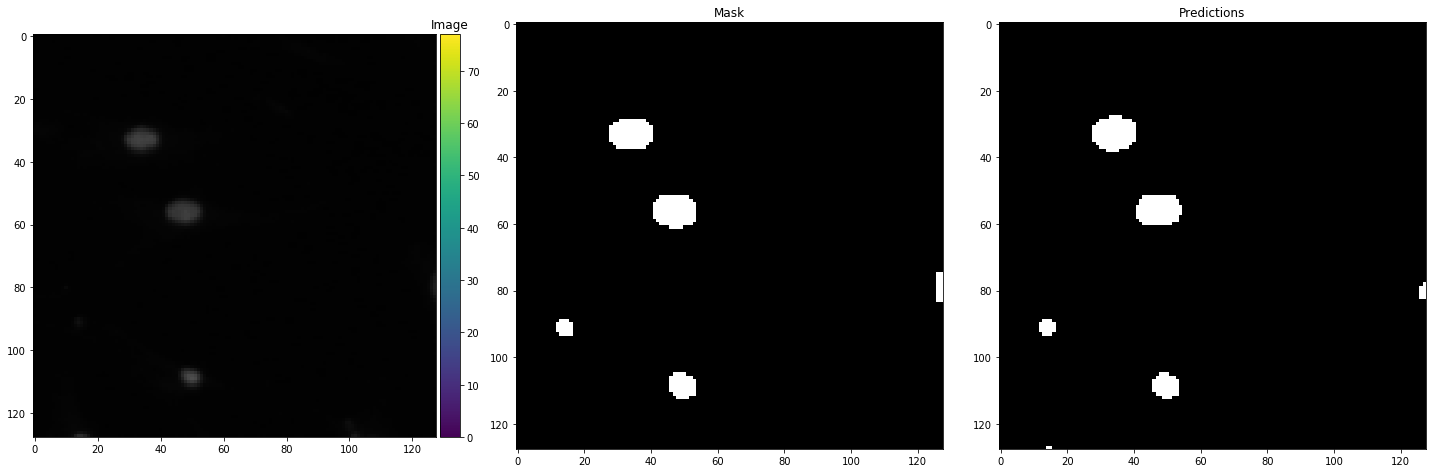

In [28]:
#On training set
#taking a random image for prediction
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Given ground truth combining all the masks
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# prediction
plt.subplot(133)
imshow(np.squeeze(final_preds_train[ix] > 0.5))
plt.title("Predictions")
plt.show()

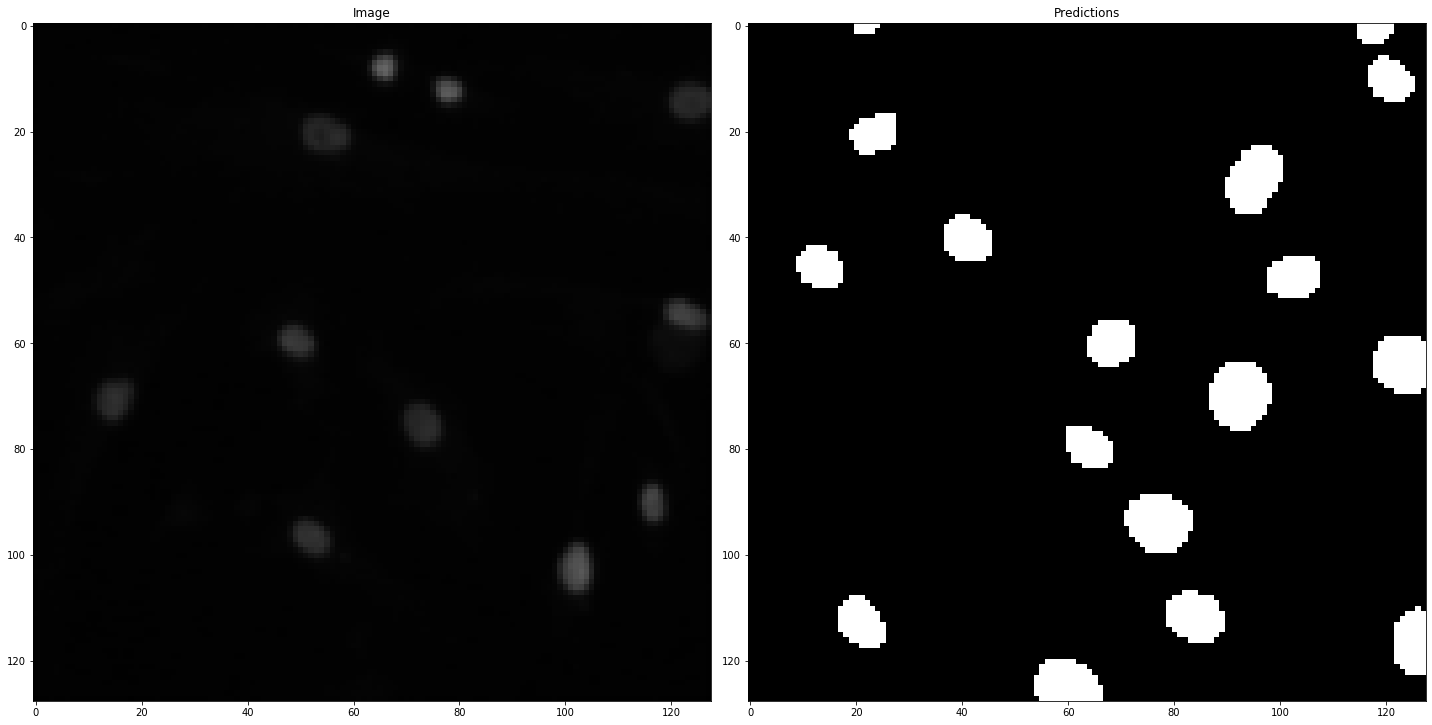

In [36]:
#On validation set
ix = random.randint(602, 668) #last 20% is the validation set
plt.figure(figsize=(20,20))
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image")
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(final_preds_val[ix] > 0.5))
plt.title("Predictions")
plt.show()